In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torchvision.io import decode_image
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms.functional as TF
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm

from dataclasses import dataclass
from clearml import Task
import os

# Config

In [2]:
@dataclass
class Config:
    DATA_PATH: str = "/home/hxastur/vscode_projects/cityscapes-segmentation/dataset"
    ANNOTATIONS_DATA_PATH: str = os.path.join(DATA_PATH, "gtFine/gtFine")
    ANNOTATIONS_TRAIN_PATH: str = os.path.join(ANNOTATIONS_DATA_PATH, "train")
    ANNOTATIONS_TEST_PATH: str = os.path.join(ANNOTATIONS_DATA_PATH, "test")
    ANNOTATIONS_VAL_PATH: str = os.path.join(ANNOTATIONS_DATA_PATH, "val")
    ANNOTATION_TYPES = ["color.png", "instanceIds.png", "labelIds.png", "polygons.json"]
    LEFT_DATA_PATH: str = os.path.join(DATA_PATH, "left/leftImg8bit")
    LEFT_TRAIN_PATH: str = os.path.join(LEFT_DATA_PATH, "train")
    LEFT_TEST_PATH: str = os.path.join(LEFT_DATA_PATH, "test")
    LEFT_VAL_PATH: str = os.path.join(LEFT_DATA_PATH, "val")
    LEFT_TYPE: str = "leftImg8bit"
    ANNOTATIONS_PREFIX: str = "gtFine"
    batch_size: int = 1
    learning_rate: float = 1e-5
    epochs: int = 5


config = Config()
device = "cuda" if torch.cuda.is_available else "spu"
print(device)

cuda


# Processor

[Github Dataset Link](https://github.com/mcordts/cityscapesScripts)

The folder structure of the Cityscapes dataset is as follows:

**{root}/{type}{video}/{split}/{city}/{city}_{seq:0>6}_{frame:0>6}_{type}{ext}**

The meaning of the individual elements is:

**root** the root folder of the Cityscapes dataset. Many of our scripts check if an environment variable CITYSCAPES_DATASET pointing to this folder exists and use this as the default choice.

**type** the type/modality of data, e.g. gtFine for fine ground truth, or leftImg8bit for left 8-bit images.

**split** the split, i.e. train/val/test/train_extra/demoVideo. Note that not all kinds of data exist for all splits. Thus, do not be surprised to occasionally find empty folders.

**city** the city in which this part of the dataset was recorded.

**seq** the sequence number using 6 digits.

**frame** the frame number using 6 digits. Note that in some cities very few, albeit very long sequences were recorded, while in some cities many short sequences were recorded, of which only the 19th frame is annotated.

**ext** the extension of the file and optionally a suffix, e.g. _polygons.json for ground truth files

In [3]:
class Processor:
    def __init__(
        self,
        LEFT_DATA_PATH,
        ANNOTATIONS_DATA_PATH,
        ANNOTATIONS_TYPES,
        ANNOTATIONS_PREFIX="_gtFine",
    ):
        self.LEFT_DATA_PATH = LEFT_DATA_PATH
        self.ANNOTATIONS_DATA_PATH = ANNOTATIONS_DATA_PATH
        self.ANNOTATIONS_PREFIX = ANNOTATIONS_PREFIX
        self.ANNOTATIONS_TYPES = ANNOTATIONS_TYPES

    def get_images(self):
        images = {}
        cities = os.listdir(self.LEFT_DATA_PATH)
        for city in cities:
            city_left_path = os.path.join(self.LEFT_DATA_PATH, city)
            files_left = os.listdir(city_left_path)
            for file in files_left:
                full_left_path = os.path.join(city_left_path, file)
                splitted = file.split("_")
                if len(splitted) != 4:
                    raise ValueError("Len of splitted != 4")
                image_type = "left"
                image_city = splitted[0]
                sequence_number = splitted[1]
                frame_number = splitted[2]
                image_name = f"{image_city}_{sequence_number}_{frame_number}"

                image_arr = images.get(image_name, {})
                image_arr.update({"left": full_left_path})
                for ANNOTATION_TYPE in self.ANNOTATIONS_TYPES:
                    annot_type = ANNOTATION_TYPE.split(".")[0]
                    image_arr.update(
                        {
                            annot_type: os.path.join(
                                self.ANNOTATIONS_DATA_PATH,
                                f"{image_city}/{image_name}{self.ANNOTATIONS_PREFIX}_{ANNOTATION_TYPE}",
                            )
                        }
                    )
                images.update({image_name: image_arr})

        for imgid in images.keys():
            if len(images[imgid]) != 5:
                raise ValueError("Len of arr %5 != 0")

        return images

# Dataset

In [4]:
class CityscapesDataset(Dataset):
    def __init__(self, processor: Processor):
        self.images = processor.get_images()
        self.keys = list(self.images.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        image_index = self.keys[idx]
        image = self.images[image_index]

        left_path = image["left"]
        color_path = image["color"]
        instanceIds_path = image["instanceIds"]
        labelIds_path = image["labelIds"]
        polygons_path = image["polygons"]

        # left = decode_image(left_path)
        # color = decode_image(color_path)

        # left = torch.tensor(cv.imread(left_path))
        # color = torch.tensor(cv.imread(color_path))

        left = Image.open(left_path)
        color = Image.open(color_path)
        # transform = transforms.Compose(
        #     [
        #         transforms.PILToTensor(),
        #     ]
        # )
        # left = transform(left)
        # color = transform(color)

        left_tensor = TF.to_tensor(left)  # C,H,W
        color_tensor = TF.to_tensor(color)

        return left_tensor, color_tensor

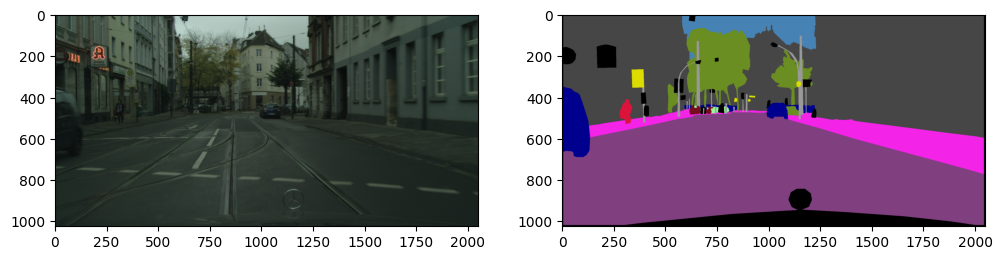

In [5]:
processor = Processor(
    LEFT_DATA_PATH=config.LEFT_TRAIN_PATH,
    ANNOTATIONS_DATA_PATH=config.ANNOTATIONS_TRAIN_PATH,
    ANNOTATIONS_TYPES=config.ANNOTATION_TYPES,
)
dataset = CityscapesDataset(processor)
left, color = next(iter(dataset))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(left.permute(1, 2, 0))
axes[1].imshow(color.permute(1, 2, 0))

# Net

In [6]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.batchnorm(self.cnn(x)))


class Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_cnn,
        pool=False,
        upsample=False,
        softmax=False,
    ):
        super(Block, self).__init__()
        self.softmax = softmax
        self.pool = pool
        self.upsample = upsample
        if num_cnn == 2:
            self.block = nn.ModuleList(
                [
                    CNNBlock(in_channels=in_channels, out_channels=out_channels),
                    CNNBlock(in_channels=out_channels, out_channels=out_channels),
                ]
            )
        if num_cnn == 3:
            self.block = nn.ModuleList(
                [
                    CNNBlock(in_channels=in_channels, out_channels=out_channels),
                    CNNBlock(in_channels=out_channels, out_channels=out_channels),
                    CNNBlock(in_channels=out_channels, out_channels=out_channels),
                ]
            )

        self.mp = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.mup = nn.MaxUnpool2d(2, stride=2)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x, ind=None):

        if self.upsample:
            x = self.mup(x, ind)
            print(f"UPSAMPLE {x.shape}")

        for module in self.block:
            x = module(x)

        if self.pool:
            x, ind = self.mp(x)
            print(f"POOL {x.shape}")
            return x, ind

        if self.softmax:
            x = self.sm(x)
        print(f"ELSE {x.shape}")
        return x


class SegNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=32, num_two=2, num_blocks=5, channel_step=64
    ):
        super(SegNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.poolblock = nn.ModuleList(
            [
                (
                    Block(
                        in_channels=(
                            channel_step * 2 ** (i - 1) if i != 0 else in_channels
                        ),
                        out_channels=channel_step * 2**i,
                        num_cnn=2 if i < num_two else 3,
                        pool=True,
                    )
                )
                for i in range(num_blocks)
            ]
        )
        self.unpoolblock = nn.ModuleList(
            [
                Block(
                    in_channels=(channel_step * 2 ** (4 - i)),
                    out_channels=(
                        channel_step * 2 ** (3 - i)
                        if i != num_blocks - 1
                        else out_channels
                    ),
                    num_cnn=2 if i < num_two else 3,
                    upsample=True,
                    softmax=True if i == num_blocks - 1 else False,
                )
                for i in range(num_blocks)
            ]
        )

    def forward(self, x):
        index_list = []
        print(self.unpoolblock)
        for module in self.poolblock:
            x, ind = module(x)
            index_list.append(ind)
        for i, module in enumerate(self.unpoolblock):
            ind = index_list[4 - i]
            print(x.shape, ind.shape)
            x = module(x, ind)
        return x

In [7]:
class DiceLoss(nn.Module):
    def init(self):
        super(DiceLoss).__init__()

    def forward(self, pred, target):
        smooth = 1
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        return 1 - ((2.0 * intersection + smooth) / (A_sum + B_sum + smooth))

# Train

In [8]:
class Trainer:
    def __init__(self, trainDataloader):
        self.trainDataloader = trainDataloader

    def train(self, net, optimizer, epochs, criterion):
        for epoch in range(epochs):
            for i, (batch_left, batch_color) in enumerate(self.trainDataloader):
                batch_left, batch_color = batch_left.to(device), batch_color.to(device)
                optimizer.zero_grad()

                output = net(batch_left)

                loss = criterion(output, batch_color)
                loss.backward()
                print(loss)
                optimizer.step()

In [9]:
processor = Processor(
    LEFT_DATA_PATH=config.LEFT_TRAIN_PATH,
    ANNOTATIONS_DATA_PATH=config.ANNOTATIONS_TRAIN_PATH,
    ANNOTATIONS_TYPES=config.ANNOTATION_TYPES,
)
dataset = CityscapesDataset(processor)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size)

trainer = Trainer(
    trainDataloader=dataloader,
)

net = SegNet(in_channels=3, out_channels=32).to(device)
optimizer = Adam(net.parameters(), lr=config.learning_rate)
criterion = DiceLoss()

trainer.train(net=net, optimizer=optimizer, epochs=config.epochs, criterion=criterion)

ModuleList(
  (0): Block(
    (block): ModuleList(
      (0): CNNBlock(
        (cnn): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (1): CNNBlock(
        (cnn): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    )
    (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (mup): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (sm): Softmax(dim=1)
  )
  (1): Block(
    (block): ModuleList(
      (0): CNNBlock(
        (cnn): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
    

RuntimeError: The size of tensor a (67108864) must match the size of tensor b (8388608) at non-singleton dimension 0

In [ ]:
processor = Processor(
    LEFT_DATA_PATH=config.LEFT_TRAIN_PATH,
    ANNOTATIONS_DATA_PATH=config.ANNOTATIONS_TRAIN_PATH,
    ANNOTATIONS_TYPES=config.ANNOTATION_TYPES,
)
dataset = CityscapesDataset(processor)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size)
data = next(iter(dataloader))

In [ ]:
data.shape